# **Custom CNN Vs. Fine-Tuning Pre-trained YOLOV8 for Human Face Detection**

# **Problem Statement**

The **goal** of this project is **to develop an accurate and efficient face detection system that can automatically locate and identify human faces in images.** 

The **key objectives** are:

* **Train a custom Convolutional Neural Network (CNN) model** that can **take an input image and output the bounding box coordinates** for the detected faces.

* **Evaluate the performance of the custom CNN model using appropriate evaluation metrics**, such as **Mean Average Precision (mAP) and Intersection over Union (IoU)**.

* **Compare the custom CNN model with a pre-trained YOLOV8 model**: Benchmark the performance of the custom CNN model against a pre-trained YOLOV8 model, which is a state-of-the-art object detection algorithm, on the same dataset.

* Develop a **Streamlit-based application** that **allows users to upload images and visualize the face detection results** from the trained models. 

## **Importing Libraries**

In [129]:
# Importing the libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization
import keras_cv
import cv2
import shutil
from ultralytics import YOLO

## **Getting Data**

* Here we will use [Kaggle](https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection) as our data repository. 
* Human Faces (Object Detection) is a dataset of diverse compilation of human facial images encompassing various races, age groups, and profiles. The **dataset comprises of 2204 images** which consists of **multiple human faces** and **a csv file which contains the bounding box coordinates for the faces**.   

In [ ]:
# Reading the faces.csv file which contains the bounding box coordinates i.e labels
df_bounding_box_labels = pd.read_csv(r'data\Human_Face_Detection_Dataset\faces.csv')

In [8]:
# Sorting the csv file based on image name in ascending order
sorted_df = df_bounding_box_labels.sort_values(by='image_name', ascending=True)

In [9]:
# images folder path 
images_folder = "data\Human_Face_Detection_Dataset\images"

# Creating a sorted list of image file paths
image_file_paths = sorted(
    [os.path.join(images_folder, fname)
     for fname in os.listdir(images_folder)
     if fname.endswith(".jpg")])

## **Exploratory Data Analysis**

In [ ]:
# Displaying the bounding box coordinates
display(df_bounding_box_labels)

image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]

In [10]:
# Printing the first five image file path
print(f"{len(image_file_paths)} image file paths found.")
print("First 5 file paths:\n", "\n".join(image_file_paths[:5]))

2204 image file paths found.
First 5 file paths:
 data\Human_Face_Detection_Dataset\images\00000003.jpg
data\Human_Face_Detection_Dataset\images\00000004.jpg
data\Human_Face_Detection_Dataset\images\00000005.jpg
data\Human_Face_Detection_Dataset\images\00000006.jpg
data\Human_Face_Detection_Dataset\images\00000008.jpg


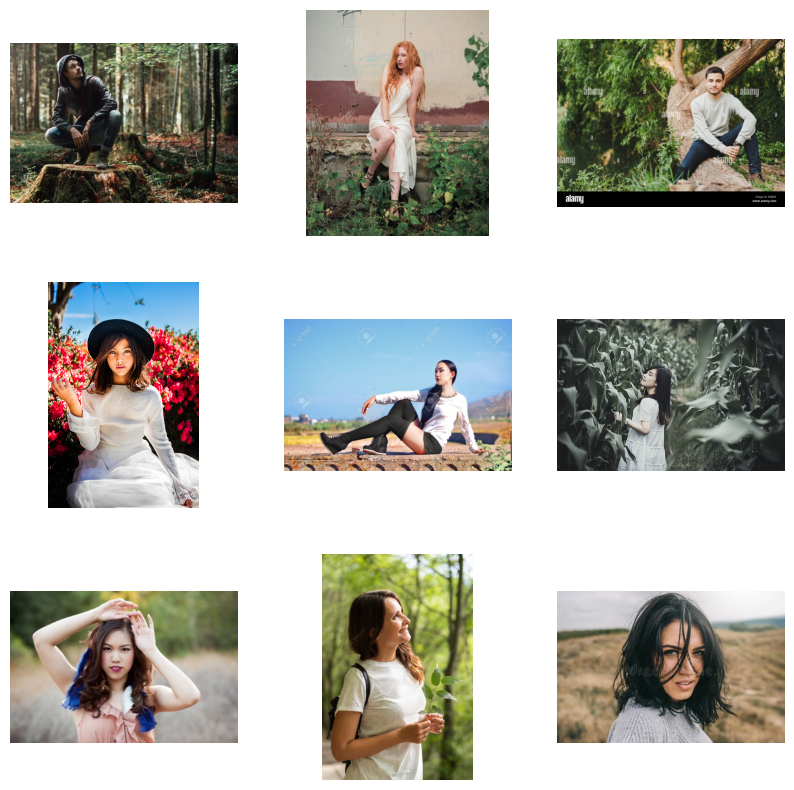

In [11]:
#Plot the first 9 images in a 3x3 grid.
plt.figure(figsize=(10, 10))
for i, image_file_path in enumerate(image_file_paths[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(load_img(image_file_path))
    plt.axis("off")

In [12]:
# getting the bounding box coordinates from the faces.csv based on image name
data = {}
for index, row in sorted_df.iterrows():
    img_name = row['image_name']
    if img_name not in data:
        data[img_name] = []
    data[img_name].append((row['x0'], row['y0'], row['x1'], row['y1']))

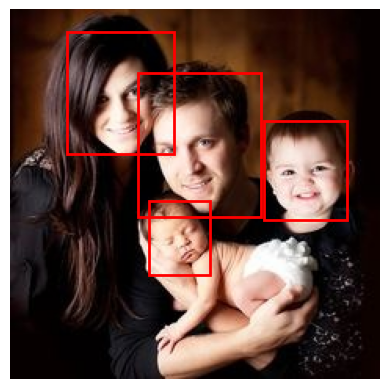

In [13]:
# Function to plot the image with bounding boxes
def plot_image_with_boxes(image_path, bounding_boxes):
    img = load_img(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in bounding_boxes:
        x0, y0, x1, y1 = bbox
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()

# Displaying a random image with bounding box
image_path = image_file_paths[2203]
image_name = os.path.basename(image_path)
bounding_boxes = data[image_name]
plot_image_with_boxes(image_path, bounding_boxes)

In [ ]:
# Calculate aspect ratios for original images
aspect_ratios_original = []
for img_path in image_file_paths:
    img_name = os.path.basename(img_path)
    width = sorted_df.loc[sorted_df['image_name'] == img_name, 'width'].iloc[0]
    height = sorted_df.loc[sorted_df['image_name'] == img_name, 'height'].iloc[0]
    aspect_ratio = width / height
    aspect_ratios_original.append(aspect_ratio)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios_original, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Original Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

IndexError: single positional indexer is out-of-bounds

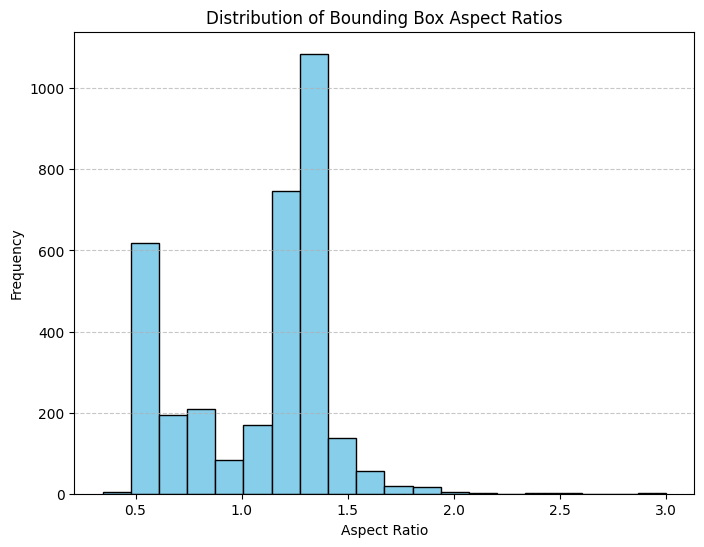

In [ ]:
# Calculate aspect ratios for bounding box
df_bounding_box_labels["Width"] = df_bounding_box_labels["x1"] - df_bounding_box_labels["x0"]
df_bounding_box_labels["Height"] = df_bounding_box_labels["y1"] - df_bounding_box_labels["y0"]
df_bounding_box_labels["Aspect_Ratio"] = df_bounding_box_labels["Width"] / df_bounding_box_labels["Height"]

# Create a histogram of aspect ratios
plt.figure(figsize=(8, 6))
plt.hist(df_bounding_box_labels["Aspect_Ratio"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Aspect Ratios")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

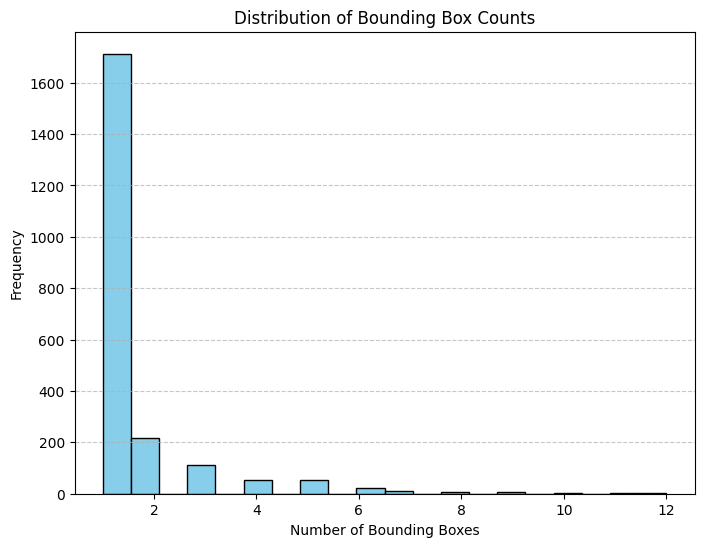

In [131]:
# Calculate the number of bounding boxes per image after resize
bbox_counts = [len(bboxes) for bboxes in new_bbox_after_resize.values()]

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(bbox_counts, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Number of Bounding Boxes")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **Data Preprocessing**

**Scaling bounding box coordinates relative to image dimensions.**

In [14]:
new_bbox_after_resize = {}
for index, row in sorted_df.iterrows():
    img_name = row['image_name']
    width = row["width"]
    height = row["height"]
    width_ratio = 224/width
    height_ratio = 224/height
    if img_name not in new_bbox_after_resize:
        new_bbox_after_resize[img_name] = []
    new_bbox_after_resize[img_name].append((int(row['x0']*width_ratio), int(row['y0']*height_ratio), int(row['x1']*width_ratio), int(row['y1']*height_ratio)))

In [15]:
target_size = (224, 224)
resized_images = []

In [16]:
# function to plot the images with bounding boxes after resizing
def plot_image_after_resize(image_path,target_size):
    img = load_img(image_path,target_size=target_size)
    image_name = os.path.basename(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    bounding_boxes = new_bbox_after_resize[image_name]
    for bbox in bounding_boxes:
        x0, y0, x1, y1 = bbox
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()
    

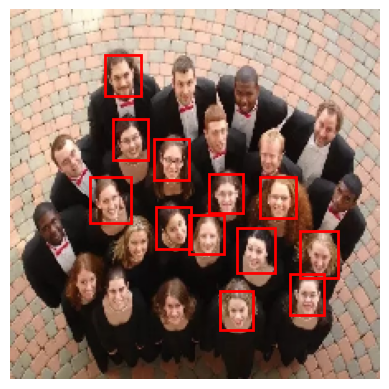

In [17]:
# Plotting a random image after resize
plot_image_after_resize(image_file_paths[295],target_size)

**Resizing images to a standard size of 224x224 pixels.**

In [18]:
# resizing the images
for image_path in image_file_paths:
    img = load_img(image_path,target_size=target_size)
    img_array = img_to_array(img)
    resized_images.append(img_array)

In [19]:
# converting the resized images as numpy array
resized_images_arr = np.array(resized_images)

In [103]:
# Printing the shape of the array
resized_images_arr.shape

(4408, 224, 224, 3)

In [104]:
# Scaling the pixel values
rescaled_images = resized_images_arr.astype('float32') / 255.0

**Getting bounding box coordinates.**

Iterating over the resized images and their corresponding bounding boxes to create the bounding box labels

In [105]:
#Initializing an empty list of bbox
bounding_boxes = []

In [106]:
# creating a list of adjusted bbox to create labels
for img_name, bboxes in new_bbox_after_resize.items():
    coord = []
    for bbox in bboxes:
        for cord in bbox:
            coord.append(cord)
    bounding_boxes.append(coord)

**Handling Variability in Bounding Box Counts:**

* To **ensure consistency in the number of bounding boxes across all images**, the **maximum number of bounding boxes among all images is determined (max_bbox)**.
Then, for each image, **if the number of bounding boxes is less than the maximum, padding is applied by appending zero coordinates to reach the maximum count**.

In [107]:
# Finding the maximum count of bounding box in a page
max_bbox = 0
for i in range(len(bounding_boxes)):
    max_bbox = max(max_bbox, len(bounding_boxes[i]))

In [108]:
# Appending zeros to the bounding box labels to reach maximum count
for i in range(len(bounding_boxes)):
    if int(max_bbox) - len(bounding_boxes[i]) != 0:
        for j in range(int(max_bbox) - len(bounding_boxes[i])):
            bounding_boxes[i].append(0)

In [109]:
# converting it as an array
bbox = np.array(bounding_boxes)

In [110]:
# Printing the shape bounding box labels
bbox.shape

(2204, 48)

## **Split the dataset to train-validation-test**

* The **dataset is split into training (80%), validation (10%) and testing (10%)**
* Random state is set to 42 to ensure reproducibility of results.

In [ ]:
# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(rescaled_images, bbox, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [ ]:
# Checking the shape of validation dataset
X_val.shape

(220, 224, 224, 3)

## **Model Training**

## **Custom CNN**

Sequential model consisting of convolutional, pooling, dropout, batch normalization, and dense layers.

* **Input shape is (224, 224, 3)** - **image data with a height and width of 224 pixels** and **three color channels (RGB)**.
* **Four convolutional layers (Conv2D)** are employed, **gradually increasing the number of filters** to capture complex patterns.
* **Max pooling (MaxPool2D) layers follow each convolutional layer to reduce spatial dimensions**, focusing on the most salient features.
* **Pool size of 2x2 (pool_size = 2)** is utilized to downsample the feature maps.
* **Dropout layers with increasing dropout rates (0.1, 0.2, 0.3, 0.4) are incorporated after each convolutional layer** to prevent overfitting .
* **Batch normalization layers are inserted after each dropout layer** to stabilize and accelerate the training process.
* **Two fully connected dense layers with 256 neurons** each follow the **global average pooling layer**.
* The **output layer consists of 48 neurons**, representing the **coordinates of bounding boxes for each detected object in the image**.
* We have used **MSE as loss function since we are doing bounding box regression task with adam optimizer**.


In [ ]:
# defining the CNN model
CNN_model = Sequential([
    Conv2D(32, 3, input_shape = (224,224,3), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48) #output layer
])

In [ ]:
# Printing the custom CNN model summary
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0

Compile the CNN model using Mean Squared Error (MSE) loss and Adam optimizer.

In [ ]:
# Compiling the custom CNN 
CNN_model.compile(loss="mse",
              optimizer="adam",
              metrics=["accuracy"])

Setting up a ModelCheckpoint callback for model to save the model weights whenever the validation loss improves

In [ ]:
# Definining the model checkpoint. saving the model with least validation loss
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_Face_Detection.keras",
        save_best_only=True,
        monitor="val_loss")
]

Training ("Fitting") the model

* **number of training epochs - 50**.
* **set the batch size to 64**. 

In [ ]:
# Training the Custom CNN
history = CNN_model.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 110s 4s/step - loss: 1339.3672 - accuracy: 0.7215 - val_loss: 1549.5322 - val_accuracy: 0.7409
Epoch 2/50
28/28 [==============================] - 101s 4s/step - loss: 983.2216 - accuracy: 0.7618 - val_loss: 1366.1924 - val_accuracy: 0.7409
Epoch 3/50
28/28 [==============================] - 100s 4s/step - loss: 719.5601 - accuracy: 0.7618 - val_loss: 1096.2998 - val_accuracy: 0.7409
Epoch 4/50
28/28 [==============================] - 105s 4s/step - loss: 627.1389 - accuracy: 0.7618 - val_loss: 922.0137 - val_accuracy: 0.7409
Epoch 5/50
28/28 [==============================] - 104s 4s/step - loss: 601.8512 - accuracy: 0.7612 - val_loss: 881.9556 - val_accuracy: 0.7409
Epoch 6/50
28/28 [==============================] - 104s 4s/step - loss: 537.3743 - accuracy: 0.7618 - val_loss: 824.8350 - val_accuracy: 0.7409
Epoch 7/50
28/28 [==============================] - 100s 4s/step - loss: 497.6294 - accuracy: 0.7618 - val_loss: 822.7520 - va

## **CNN Model Evaluation**

* The **Mean IOU** is an **important metric to measure the accuracy of object localization**.
* The **Mean IOU of training, validation and testing dataset** when **considering only actual bounding box coordinates is 0.16,0.15,0.15 respectively**.
* The **Mean IOU is less that 0.5 and is nearly equal to zero** which **indicates the poor performance of the model**.
* And **from the plotted images**, **we can clearly understand that the model struggles to predict the exact bounding boxes of faces** in images.
* Also **there are additional small bounding boxes plotted which are not actual faces**. This **occurs due to extra zeros appended to bounding box coordinates to reach the maximum count of 12 faces**. 

In [104]:
# Loading the saved model
CNN_test_model = keras.models.load_model(
    "./models/CNN_Face_Detection.keras")

In [ ]:
# Define a function to plot images with bounding boxes
def plot_images_with_boxes(images, boxes):
    num_images = len(images)
    num_cols = 2
    num_rows = 2
    
    plt.figure(figsize=(7, 5))
    
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i])
        
        for box in boxes[i].reshape(12,4):
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none'))
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to calculate the Mean IOU (Intersection Over Union ) for the dataset
def calculate_MeanIOU(predicted_bbox,ground_truth_bbox):
    mean_iou_scores = np.zeros(predicted_bbox.shape[0])
    for i in range(predicted_bbox.shape[0]):
        valid_ground_truth_boxes = ground_truth_bbox[i][np.any(ground_truth_bbox[i] != 0, axis=1)]
        valid_predicted_boxes = predicted_bbox[i][:len(valid_ground_truth_boxes)]
        iou_score = keras_cv.bounding_box.compute_iou( boxes1=valid_predicted_boxes, boxes2=valid_ground_truth_boxes, bounding_box_format='xyxy',use_masking=True,mask_val = 0).numpy()
        mean_iou = np.mean(iou_score)
        mean_iou_scores[i] = mean_iou
    return np.mean(mean_iou_scores)


In [ ]:
# Predicting on the training dataset
train_bounding_boxes = CNN_test_model.predict(X_train)

56/56 [==============================] - 14s 240ms/step


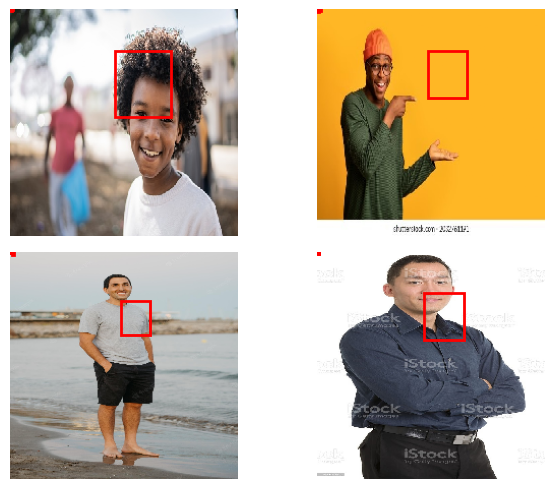

In [ ]:
# Rounding the bounding box coordinates and converting it as integers
train_predicted_bounding_boxes= np.round(train_bounding_boxes).astype(int)

# Plotting the first 4 images with the predicted bounding boxes
num_samples =  4  # Plot up to 4 images
plot_images_with_boxes(X_train[:num_samples], train_predicted_bounding_boxes[:num_samples])

In [ ]:
# Reshaping the predicted bbox coordinates to calculate the Mean IOU of training dataset
predicted_train_box_reshaped = train_predicted_bounding_boxes.reshape(X_train.shape[0],12,4)
train_ground_truth =y_train.reshape(y_train.shape[0],12,4)

In [ ]:
print("Mean Intersection Over Union for Training dataset ",calculate_MeanIOU(predicted_train_box_reshaped,train_ground_truth))

Mean Intersection Over Union for Training dataset  0.16198702135663426


In [ ]:
# Predicting on the validation dataset
Val_bounding_boxes = CNN_test_model.predict(X_val)

7/7 [==============================] - 2s 284ms/step


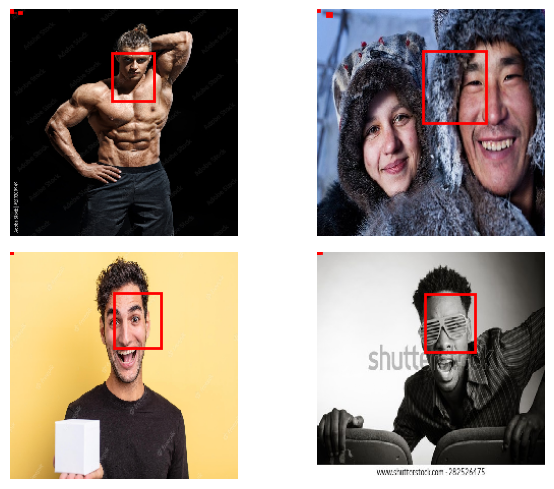

In [ ]:
# Rounding the bounding box coordinates and converting it as integers
val_predicted_bounding_boxes= np.round(Val_bounding_boxes).astype(int)

# Plotting the first 4 images with the predicted bounding boxes
num_samples =  4  # Plot up to 4 images
plot_images_with_boxes(X_val[:num_samples], val_predicted_bounding_boxes[:num_samples])

In [ ]:
# Reshaping the predicted bbox coordinates to calculate the Mean IOU of validation dataset
predicted_val_box_reshaped = val_predicted_bounding_boxes.reshape(220,12,4)
val_ground_truth =y_val.reshape(220,12,4)

In [ ]:
print("Mean Intersection Over Union for Validation dataset ",calculate_MeanIOU(predicted_val_box_reshaped,val_ground_truth))

Mean Intersection Over Union for Validation dataset  0.150789400686203


In [ ]:
# Predicting on the training dataset
test_bounding_boxes = CNN_test_model.predict(X_test)

7/7 [==============================] - 2s 293ms/step


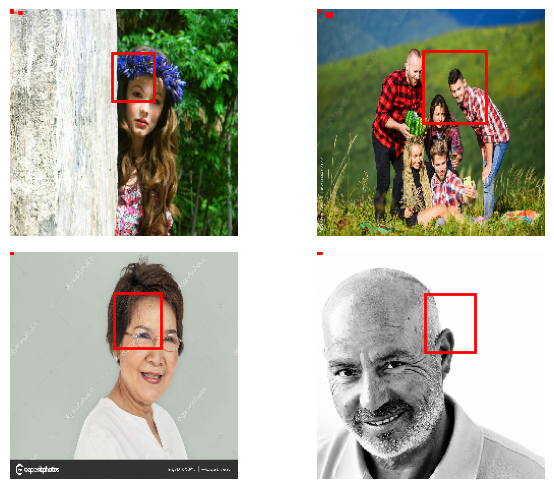

In [ ]:
# Rounding the bounding box coordinates and converting it as integers
test_predicted_bounding_boxes= np.round(test_bounding_boxes).astype(int)

# Plotting the first 4 images with the predicted bounding boxes
num_samples =  4  # Plot up to 4 images
plot_images_with_boxes(X_test[:num_samples], val_predicted_bounding_boxes[:num_samples])

In [ ]:
# Reshaping the predicted bbox coordinates to calculate the Mean IOU of training dataset
predicted_test_box_reshaped = test_predicted_bounding_boxes.reshape(X_test.shape[0],12,4)
test_ground_truth =y_test.reshape(y_test.shape[0],12,4)

In [ ]:
print("Mean Intersection Over Union for Testing dataset ",calculate_MeanIOU(predicted_test_box_reshaped,test_ground_truth))

Mean Intersection Over Union for Testing dataset  0.15025931122350375


## **YOLOV8** 

**YOLOv8 consists of 225 layers with around 3157200 parameters**

## **Data Preprocessing**

Below preprocessing steps are crucial for the YOLOV8 model, as it expects the input data to be in a specific format

* The **images are split into training, validation and testing**. Segregated the images into separate folders
* Also we **created labels for each image as a text file and segregated the labels into separate folders** as training, validation and testing
* The **coordinates of the bounding boxes should be in the format of X-center, Y-center, bounding box width and bounding box height**.
* In-addition to this, we have **created the config.yaml file which contains the path to training, validation and testing images dataset, number of classes, class labels**.

In [20]:
# getting the list of image file names
face_list=os.listdir(images_folder)

In [21]:
# Splitting the image file names into training (80%), validation (10%) and testing (10%)
imgtrain_list=face_list[:int(len(face_list)*0.8)]
imgval_list=face_list[int(len(face_list)*0.8):int(len(face_list)*(0.8+0.1))]
imgtest_list=face_list[int(len(face_list)*(0.8+0.1)):]

### **Convert image filenames to label filenames**

Create label filenames for each image filename by mapping the extension from .jpg to .txt.

In [22]:
# Function to change the extension from .jpeg to .txt
def change_extension(file):
    basename=os.path.splitext(file)[0]
    filename=basename+'.txt'
    return filename

In [23]:
# preparing the list of label file names for training, validation and testing
labeltrain_list = list(map(change_extension, imgtrain_list)) 
labelval_list = list(map(change_extension, imgval_list)) 
labeltest_list = list(map(change_extension, imgtest_list)) 

### **Preprocess the bounding box annotations**

* **Calculate the center coordinates (x_centre, y_centre), bounding box width (bb_width), and bounding box height (bb_height)** for each face.
* **Scale these values relative to the image width and height** to get the **normalized bounding box coordinates (xcentre_scaled, ycentre_scaled, width_scaled, height_scaled)**.

In [24]:
# calculating the X-center, y-center, bb_width and bb_height
sorted_df['x_centre']=0.5*(sorted_df['x0']+sorted_df['x1'])
sorted_df['y_centre']=0.5*(sorted_df['y0']+sorted_df['y1'])
sorted_df['bb_width']=sorted_df['x1']-sorted_df['x0']
sorted_df['bb_height']=sorted_df['y1']-sorted_df['y0']
sorted_df

image_name  width  height    x0   y0    x1    y1  x_centre  y_centre   
586   00000003.jpg    500     350   101   25   176    87     138.5      56.0  \
87    00000004.jpg   1000    1241   476  177   588   335     532.0     256.0   
173   00000005.jpg   1300     957   811  171   976   313     893.5     242.0   
396   00000006.jpg   2667    4000  1002  787  1547  1739    1274.5    1263.0   
3167  00000008.jpg   1300     867   820  234  1016   387     918.0     310.5   
...            ...    ...     ...   ...  ...   ...   ...       ...       ...   
3278  00003514.jpg    236     354    93   37   133   106     113.0      71.5   
3063  00003517.jpg    236     236    81   40   160   132     120.5      86.0   
3064  00003517.jpg    236     236   162   71   215   134     188.5     102.5   
3065  00003517.jpg    236     236    36   14   104    92      70.0      53.0   
3066  00003517.jpg    236     236    88  122   127   169     107.5     145.5   

      bb_width  bb_height  
586         75         62  
87         112        158  
173        165        142  
396        545        952  
3167       196        153  
...        ...        ...  
3278        40         69  
3063        79         92  
3064        53         63  
3065        68         78  
3066        39         47  

[3350 rows x 11 columns]

In [25]:
# Scaling/Normalizing the bounding box coordinates
sorted_df['xcentre_scaled']=sorted_df['x_centre']/sorted_df['width']
sorted_df['ycentre_scaled']=sorted_df['y_centre']/sorted_df['height']
sorted_df['width_scaled']=sorted_df['bb_width']/sorted_df['width']
sorted_df['height_scaled']=sorted_df['bb_height']/sorted_df['height']
sorted_df

image_name  width  height    x0   y0    x1    y1  x_centre  y_centre   
586   00000003.jpg    500     350   101   25   176    87     138.5      56.0  \
87    00000004.jpg   1000    1241   476  177   588   335     532.0     256.0   
173   00000005.jpg   1300     957   811  171   976   313     893.5     242.0   
396   00000006.jpg   2667    4000  1002  787  1547  1739    1274.5    1263.0   
3167  00000008.jpg   1300     867   820  234  1016   387     918.0     310.5   
...            ...    ...     ...   ...  ...   ...   ...       ...       ...   
3278  00003514.jpg    236     354    93   37   133   106     113.0      71.5   
3063  00003517.jpg    236     236    81   40   160   132     120.5      86.0   
3064  00003517.jpg    236     236   162   71   215   134     188.5     102.5   
3065  00003517.jpg    236     236    36   14   104    92      70.0      53.0   
3066  00003517.jpg    236     236    88  122   127   169     107.5     145.5   

      bb_width  bb_height  xcentre_scaled  ycentre_scaled  width_scaled   
586         75         62        0.277000        0.160000      0.150000  \
87         112        158        0.532000        0.206285      0.112000   
173        165        142        0.687308        0.252874      0.126923   
396        545        952        0.477878        0.315750      0.204349   
3167       196        153        0.706154        0.358131      0.150769   
...        ...        ...             ...             ...           ...   
3278        40         69        0.478814        0.201977      0.169492   
3063        79         92        0.510593        0.364407      0.334746   
3064        53         63        0.798729        0.434322      0.224576   
3065        68         78        0.296610        0.224576      0.288136   
3066        39         47        0.455508        0.616525      0.165254   

      height_scaled  
586        0.177143  
87         0.127317  
173        0.148380  
396        0.238000  
3167       0.176471  
...             ...  
3278       0.194915  
3063       0.389831  
3064       0.266949  
3065       0.330508  
3066       0.199153  

[3350 rows x 15 columns]

In [26]:
# grouping the bounding box coordinates based on image name
imgs=sorted_df.groupby('image_name') 

In [27]:
# getting the current working directory path
curr_path=os.getcwd()
# framing the folder paths to move images into corresponding training, testing and validation folders
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

# framing the folders to move the labels text files into corresponding training, testing and validation folders
labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

In [241]:
# Initial path where the labels text files will be created
labels_path = os.path.join(curr_path, 'face_labels')

In [243]:
# Creating the initial labels directory Once it is moved we, will delete this folder
os.makedirs(labels_path)

In [28]:
# Data path to dataset folder
data_path= 'data\YOLO_Format'

### **Generating the label files**

Iterates over the grouped images and generates the label files in the YOLOV8 format with the calculated coordinates.

In [244]:

# Iterating the grouped dataframe based on image name to get the coordinates and writing it to the labels file
for image in imgs:
    img_df=imgs.get_group(image[0])
    basename=os.path.splitext(image[0])[0]
    txt_file=basename+'.txt'
    filepath=os.path.join(labels_path, txt_file)
    lines=[]
    i=1
    for index,row in img_df.iterrows():
        if i!=len(img_df):
            line=str(0)+' '+str(row['xcentre_scaled'])+' '+str(row['ycentre_scaled'])+' '+str(row['width_scaled'])+' '+str(row['height_scaled'])+'\n'
            lines.append(line)
        else:
            line=str(0)+' '+str(row['xcentre_scaled'])+' '+str(row['ycentre_scaled'])+' '+str(row['width_scaled'])+' '+ str(row['height_scaled'])
            lines.append(line)
        i=i+1
    with open(filepath, 'w') as file:
        file.writelines(lines)

In [263]:
# Function to move label files in the appropriate directories
def move_files(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        shutil.move(filepath, dest_path)
        i=i+1
    print("Number of files transferred:", i)

In [254]:
# Function to resize the images to 640x640 pixels and moves them into the appropriate directories.
def move_images(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        finalimage_path=os.path.join(dest_path, file)
        print(filepath)
        img_resized=cv2.resize(cv2.imread(filepath), (640, 640))
        cv2.imwrite(finalimage_path, img_resized)
        i=i+1
    print("Number of files transferred:", i)

In [257]:
# Creating the separate images folder
img_path=os.path.join(data_path, 'images')

Move the image and label files to their respective directories for the training, validation, and test sets.

In [ ]:
# Moving the training images into training folder
move_images(imgtrain_list, img_path, imgtrainpath)

In [ ]:
# Moving the validation images into validation folder
move_images(imgval_list, img_path, imgvalpath)

In [ ]:
# Moving the testing images into testing folder
move_images(imgtest_list, img_path, imgtestpath)

In [264]:
# Moving the training labels into training folder
move_files(labeltrain_list, labels_path, labeltrainpath)

Number of files transferred: 1763


In [265]:
# Moving the validation labels into validation folder
move_files(labelval_list, labels_path, labelvalpath)

Number of files transferred: 220


In [266]:
# Moving the testing labels into testing folder
move_files(labeltest_list, labels_path, labeltestpath)

Number of files transferred: 221


Generate a configuration file for the YOLOV8 model to specify the paths for the training, validation, and test sets, as well as the class names .

In [33]:
# Creating the contents of the configuration file
ln_1='# Train/val/test sets'+'\n'
ln_2='train: ' +"'"+imgtrainpath+"'"+'\n'
ln_3='val: ' +"'" + imgvalpath+"'"+'\n'
ln_4='test: ' +"'" + imgtestpath+"'"+'\n'
ln_5='\n'
ln_6='# Classes'+'\n'
ln_7='names:'+'\n'
ln_8='  0: face'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8]

In [34]:
# Giving the path to configuration file to get saved
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'c:\\Users\\hemas\\Documents\\Applied_AI_and_ML_Courses\\Foundations_Of_ML\\labs\\Human-Face-detection\\config.yaml'

In [269]:
# Writing the contents into the configuration file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

## **Model Training**

In [307]:
# Loading the pre-trained YOLOV8 nano model
model=YOLO('yolov8n.pt')

In [308]:
# Printing the model information
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [310]:
# Traing the model on our dataset for 10 epochs with adam optimizer
results=model.train(data=config_path,imgsz=640,epochs=10,patience=20,optimizer='Adam',lr0=0.001,lrf=0.01,device='cpu')

Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\config.yaml, epochs=10, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fal

train: Scanning C:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\data\YOLO_Format\labels\train.cache... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:00<?, ?it/s]
val: Scanning C:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\data\YOLO_Format\labels\validation.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]

Plotting labels to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\labels.jpg... 


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.418      1.401      1.532         11        640: 100%|██████████| 111/111 [09:17<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:26<00:00,  3.79s/it]

                   all        220        411       0.72      0.698      0.715      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.211     0.8987      1.354          3        640: 100%|██████████| 111/111 [08:47<00:00,  4.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]

                   all        220        411       0.81      0.789      0.862      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.149     0.7636      1.334          3        640: 100%|██████████| 111/111 [1:01:19<00:00, 33.15s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:27<00:00,  3.98s/it]

                   all        220        411      0.778        0.9      0.825      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.084     0.7089      1.271          6        640: 100%|██████████| 111/111 [09:50<00:00,  5.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.43s/it]

                   all        220        411       0.82      0.878      0.918       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.038     0.6607      1.249          3        640: 100%|██████████| 111/111 [10:44<00:00,  5.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.57s/it]

                   all        220        411       0.83      0.929      0.925      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.9795     0.5966       1.19          3        640: 100%|██████████| 111/111 [09:15<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.68s/it]

                   all        220        411       0.81      0.953      0.934       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.9133     0.5672      1.159          3        640: 100%|██████████| 111/111 [08:53<00:00,  4.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]

                   all        220        411      0.892      0.903      0.937      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.8562     0.5321      1.121          4        640: 100%|██████████| 111/111 [08:27<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:26<00:00,  3.72s/it]

                   all        220        411      0.891      0.937      0.957      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.8158      0.499      1.095          3        640: 100%|██████████| 111/111 [08:34<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

                   all        220        411      0.876      0.937      0.953      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7864     0.4724      1.076          4        640: 100%|██████████| 111/111 [08:05<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

                   all        220        411      0.876      0.925      0.951      0.743



10 epochs completed in 2.464 hours.
Optimizer stripped from c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\weights\best.pt, 6.2MB

Validating c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.96s/it]


                   all        220        411      0.878      0.926      0.951      0.743
Speed: 2.7ms preprocess, 85.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5


## **Model Evaluation**

* The **Mean Average precision under IOU threshold of 0.5 is 95%** for **both validation and testing dataset** indicates **good performance of the model to detect faces**.
* Also the **Mean IOU on the validation and testing dataset is around 0.61 and 0.64 respectively** which is also pretty good.
* **Precision of predicting the bounding box coordinates is around 88% on validation and 84% on testing dataset**
* **Recall of predicting the bounding box coordinates is around 93% on validation and 96% on testing dataset**.

In [29]:
# Loading the best weights of the pre-trained model
path_to_best_weights = r'C:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\weights\best.pt'
fine_tuned_model = YOLO(path_to_best_weights)

In [ ]:
# Making predictions on the validation dataset
results_val = fine_tuned_model.predict(source= r'data\YOLO_Format\images\validation',save = True)

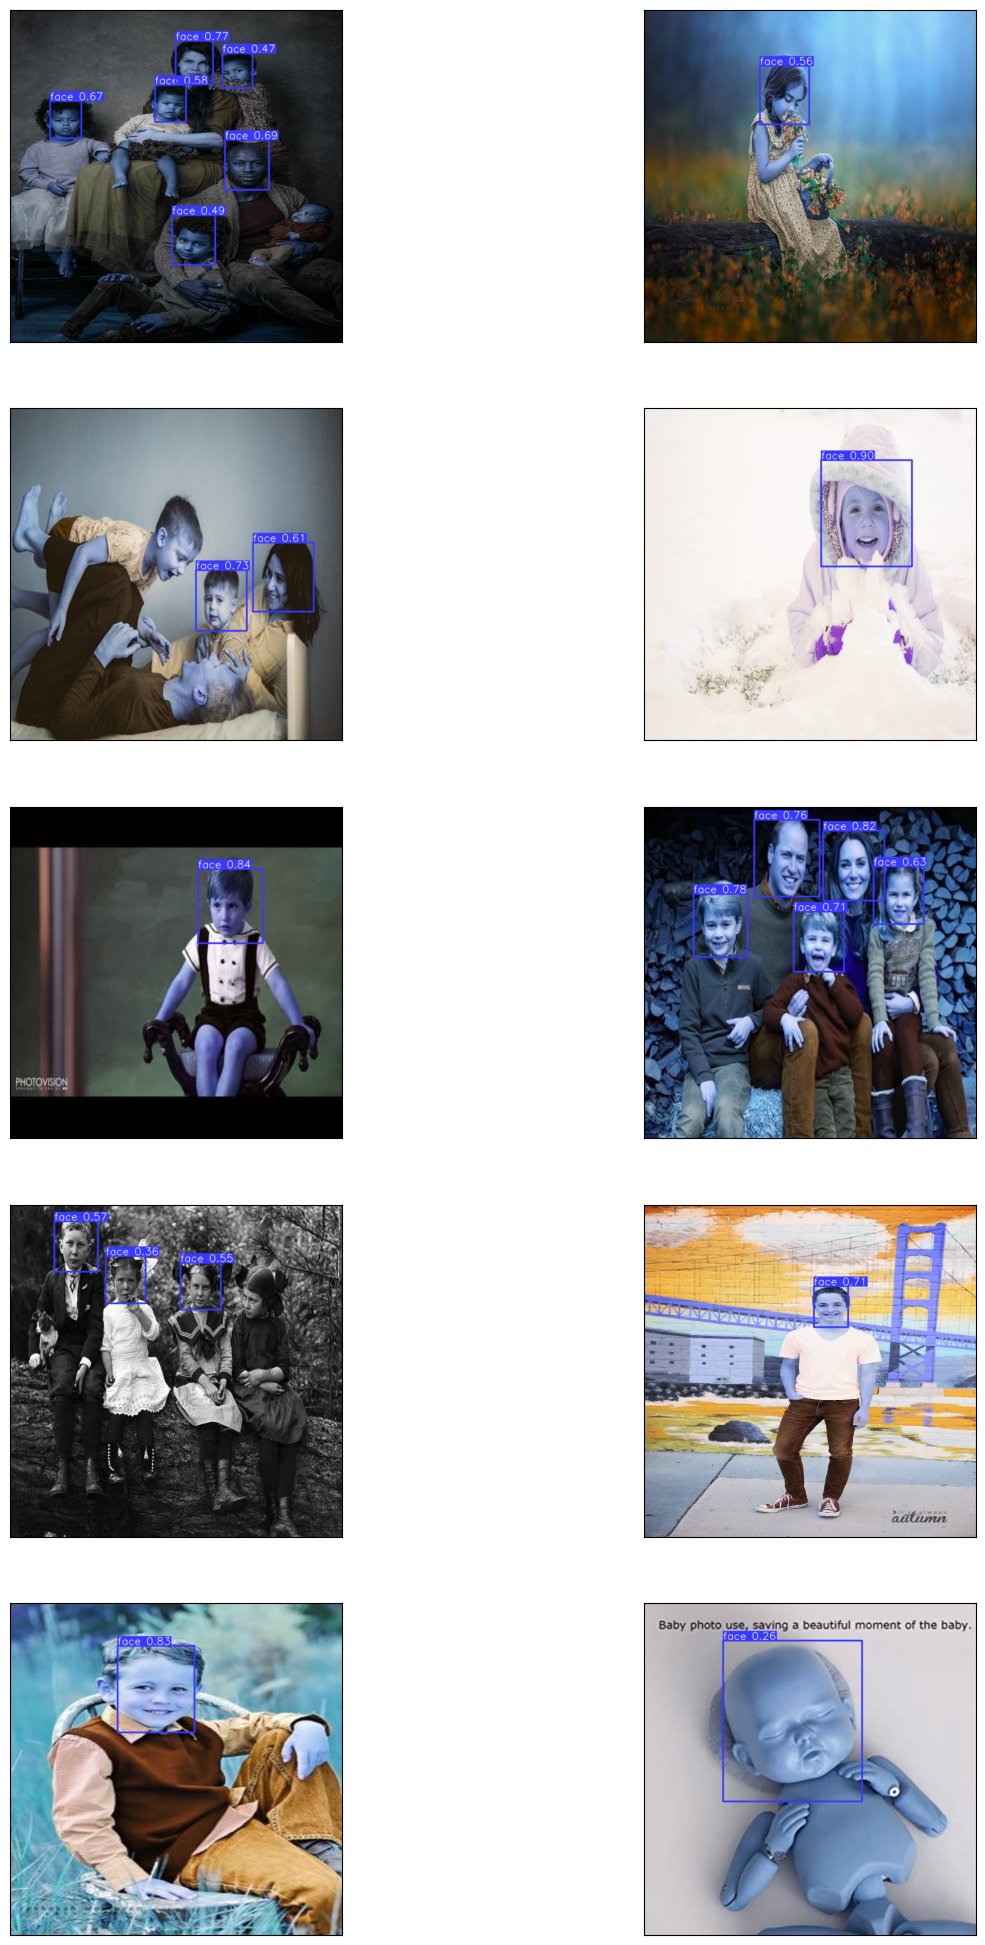

In [31]:
# Plotting the first 10 images with the predicted labels for the validation dataset
plt.figure(figsize=(15,25))
for index,result in enumerate(results_val[:10]):
    # Load the image
    res_plotted = result.plot()
    ax=plt.subplot(5,2,index+1)
    
    # Display image with predictions
    plt.imshow(res_plotted)
    plt.xticks([])
    plt.yticks([])

In [35]:
# Evaluating the model and getting the metrics on validation dataset
metrics=fine_tuned_model.val(data=config_path, split='val')

Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)


val: Scanning C:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\data\YOLO_Format\labels\validation.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:23<00:00,  1.70s/it]


                   all        220        411      0.878      0.926      0.951      0.743
Speed: 2.1ms preprocess, 91.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\val5


In [36]:
# Printing the metrics such as maP50-95(Mean Average Precision under IOU threshold of 0.50 to 0.95), (Mean Average Precision under IOU threshold of 0.50, Precision, Recall and F1-score of bounding box)
print(f"mAP50-95 for Validation data: {metrics.box.map:.2f}")
print(f"mAP50 for Validation data: {metrics.box.map50:.2f}")
print(f"Precision for Validation data: {metrics.box.p[0]:.2f}")
print(f"Recall for Validation data: {metrics.box.r[0]:.2f}")
print(f"F1-score for Validation data: {metrics.box.f1[0]:.2f}")

mAP50-95 for Validation data: 0.74
mAP50 for Validation data: 0.95
Precision for Validation data: 0.88
Recall for Validation data: 0.93
F1-score for Validation data: 0.90


In [ ]:
# Making predictions on the testing dataset
results_test = fine_tuned_model.predict(source= r'data\YOLO_Format\images\test',save = True)

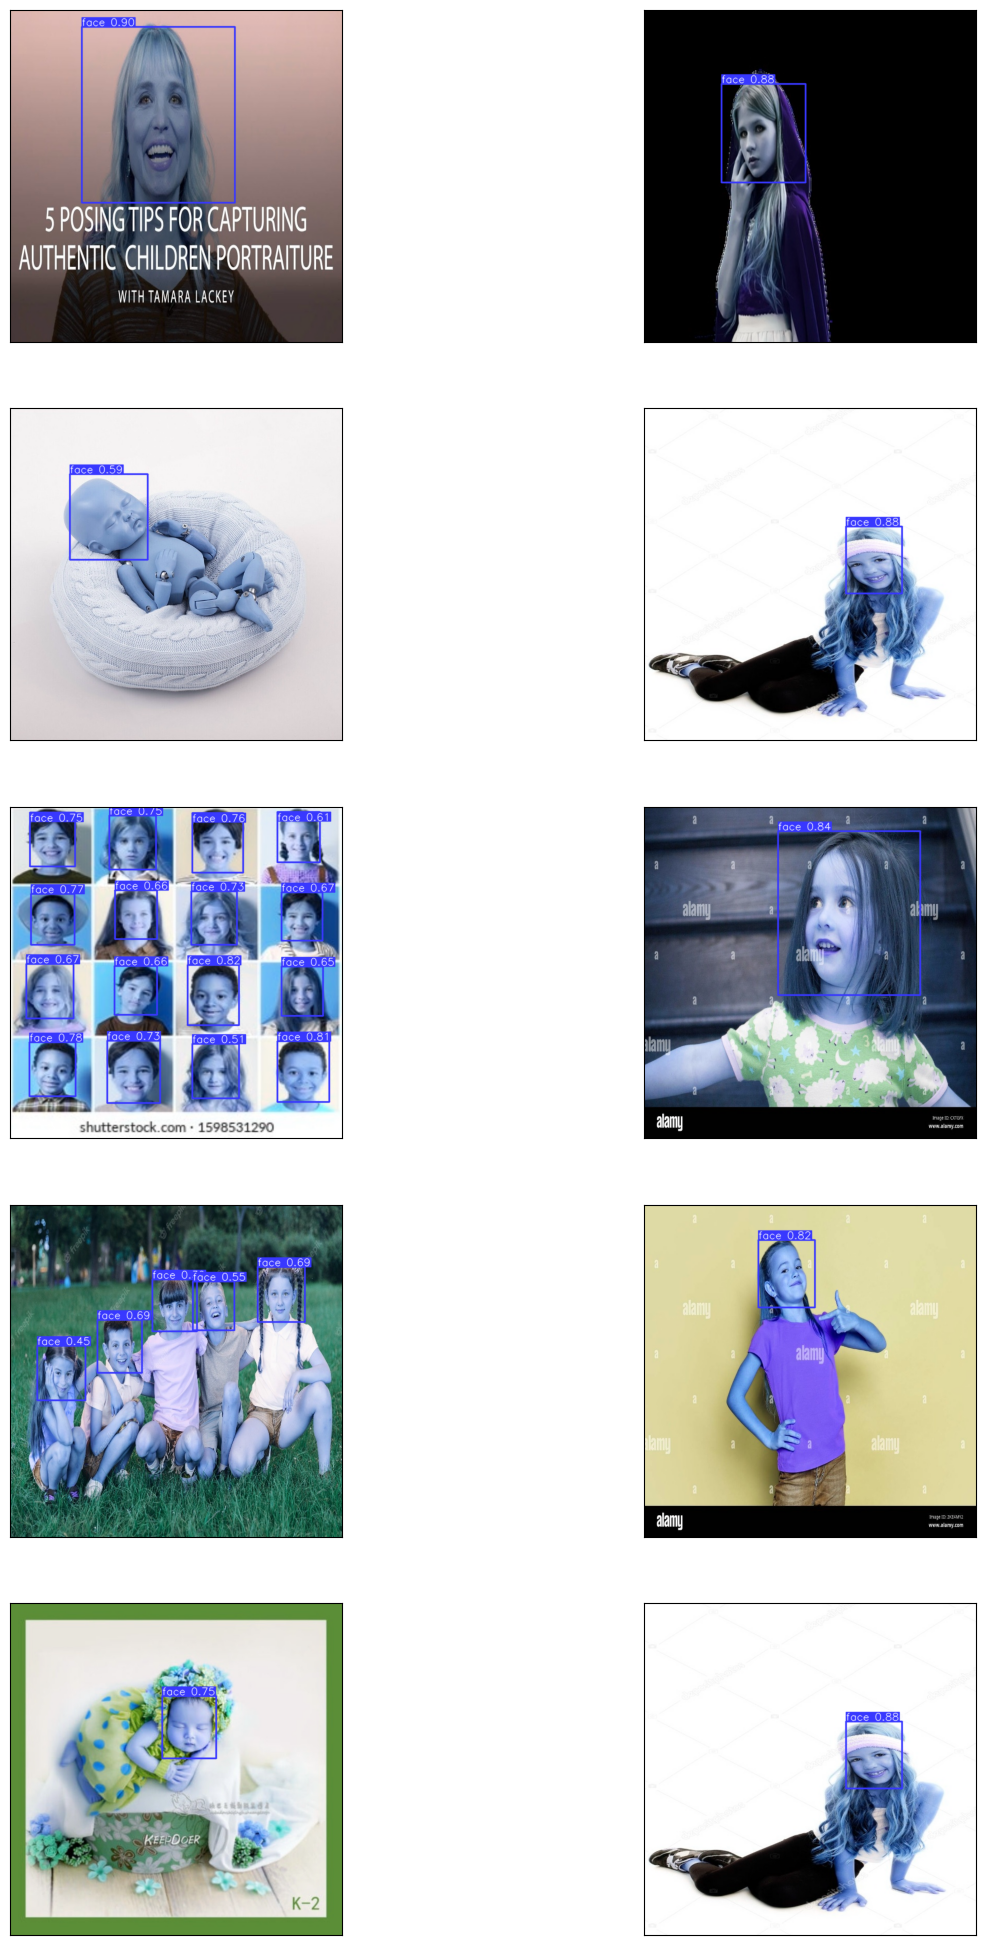

In [38]:
# Plotting the first 10 images with the predicted labels for the testing dataset
plt.figure(figsize=(15,25))
for index,result in enumerate(results_test[:10]):
    # Load the image
    res_plotted = result.plot()
    ax=plt.subplot(5,2,index+1)
    
    # Display image with predictions
    plt.imshow(res_plotted)
    plt.xticks([])
    plt.yticks([])

In [39]:
# Evaluating the model and getting the metrics on testing dataset
metrics_test=fine_tuned_model.val(data=config_path, split='test')

Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)


val: Scanning C:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\data\YOLO_Format\labels\test.cache... 221 images, 0 backgrounds, 0 corrupt: 100%|██████████| 221/221 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:22<00:00,  1.63s/it]


                   all        221        391      0.837      0.958      0.946      0.733
Speed: 1.7ms preprocess, 90.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\val6


In [40]:
# Printing the metrics such as maP50-95(Mean Average Precision under IOU threshold of 0.50 to 0.95), (Mean Average Precision under IOU threshold of 0.50, Precision, Recall and F1-score of bounding box)
print(f"mAP50-95 for Testing data: {metrics_test.box.map:.2f}")
print(f"mAP50 for Testing data: {metrics_test.box.map50:.2f}")
print(f"Precision for Testing data: {metrics_test.box.p[0]:.2f}")
print(f"Recall for Testing data: {metrics_test.box.r[0]:.2f}")
print(f"F1-score for Testing data: {metrics_test.box.f1[0]:.2f}")

mAP50-95 for Testing data: 0.73
mAP50 for Testing data: 0.95
Precision for Testing data: 0.84
Recall for Testing data: 0.96
F1-score for Testing data: 0.89


### **Calculating the Mean IOU on Validation and Testing dataset**

There is **no direct way to get the Mean IOU for YOLOV8**. So, **calulating the Mean IOU manually**.

* First **we got the predicted bounding box coordinates from the model as a list**.
* Also **got the ground truth bounding box coordinates from the labels text files**.
* **Iterated over bounding box pairs of each image**. **Calculated the IOU**. **Took the mean of it** which is the **Mean IOU of that particular image**.
* **Mean IOU is computed for each image**.
* Finally took the **average of the Mean IOU of all the images** in the validation and test dataset

In [50]:
# Initializing a empty list
predicted_boxes = []

In [51]:
# getting the predicted bounding box labels from the model
for result in results_val:
    predicted_boxes.append(result.boxes.xywh.tolist())

In [43]:
# Function to parse the label text files to get the normalized bounding box coordinates. Converting the normalized coordinates to actual
# X-center, Y-center, bb_width and bb-height values
def parse_annotation(annotation_path, image_width, image_height):
    boxes = []
    with open(annotation_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_index, x_center_norm, y_center_norm, width_norm, height_norm = map(float, line.strip().split())
            
            # Convert normalized coordinates to pixel coordinates
            x_center = int(x_center_norm * image_width)
            y_center = int(y_center_norm * image_height)
            width = int(width_norm * image_width)
            height = int(height_norm * image_height)
            
            
            boxes.append((x_center, y_center, width, height))
    return boxes

In [44]:
# specifying the directory path to validation labels folder
labels_dir = "C:\\Users\\hemas\\Documents\\Applied_AI_and_ML_Courses\\Foundations_Of_ML\\labs\\Human-Face-detection\\data\\YOLO_Format\\labels\\validation"
image_width, image_height = 640, 640

In [45]:
# Initializing a empty list
groundtruth_boxes = []

In [46]:
# Parsing the annotation files and getting the groundtruth labels
for label_filename in labelval_list:
    annotation_path = os.path.join(labels_dir,label_filename)
    boxes = parse_annotation(annotation_path, image_width, image_height)
    groundtruth_boxes.append(boxes)

In [47]:
# Function to calculate the Intersection Over Union
def calculate_iou(box1, box2):
    # Extract coordinates and dimensions
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate coordinates of intersection rectangle
    x_left = max(x1 - w1 / 2, x2 - w2 / 2)
    y_top = max(y1 - h1 / 2, y2 - h2 / 2)
    x_right = min(x1 + w1 / 2, x2 + w2 / 2)
    y_bottom = min(y1 + h1 / 2, y2 + h2 / 2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Calculate intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate area of each bounding box
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    # Calculate union area
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    
    return iou

In [71]:
# calculating the Mean IOU for each image in the validation dataset
image_iou = []
for index, _ in enumerate(groundtruth_boxes):
    iou_score = []
    for gt_box, pred_box in zip(groundtruth_boxes[index], predicted_boxes[index]):
        iou = calculate_iou(gt_box, pred_box)
        iou_score.append(iou)
    image_iou.append(np.mean(iou_score))
    

In [82]:
print("YOLOV8 Mean IOU for the validation dataset ",np.nanmean(image_iou))

YOLOV8 Mean IOU for the validation dataset  0.6169596333886281


In [83]:
# Initializing a empty list
predicted_boxes_test = []

In [84]:
# getting the predicted bounding box labels from the model
for result in results_test:
    predicted_boxes_test.append(result.boxes.xywh.tolist())

In [88]:
# specifying the directory path to testing labels folder
test_labels_dir = "C:\\Users\\hemas\\Documents\\Applied_AI_and_ML_Courses\\Foundations_Of_ML\\labs\\Human-Face-detection\\data\\YOLO_Format\\labels\\test"

In [86]:
# Initializing a empty list
groundtruth_boxes_test = []

In [89]:
# Parsing the annotation files and getting the groundtruth labels
for label_filename in labeltest_list:
    annotation_path = os.path.join(test_labels_dir,label_filename)
    boxes = parse_annotation(annotation_path, image_width, image_height)
    groundtruth_boxes_test.append(boxes)

In [ ]:
# calculating the Mean IOU for each image in the validation dataset
image_iou_test = []
for index, _ in enumerate(groundtruth_boxes_test):
    iou_score = []
    for gt_box, pred_box in zip(groundtruth_boxes_test[index], predicted_boxes_test[index]):
        iou = calculate_iou(gt_box, pred_box)
        iou_score.append(iou)
    image_iou_test.append(np.mean(iou_score))

In [95]:
print("YOLOV8 Mean IOU for the test dataset ",np.nanmean(image_iou_test))

YOLOV8 Mean IOU for the test dataset  0.6463427945313658
